In [1]:
import sys
sys.path.append('/Users/hannahnesser/Documents/Harvard/Research/Python')

import hippo_curtains as curtains
import process_hippo as ph
import strat_sep as ss
import basic_funcs
import vert_profs as vp
import tot_col as tc
import map_plots as mp
import bias_eval as bias

import numpy as np 
import pandas as pd 

import datetime
import parse

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline

matplotlib.rcParams['font.size'] = 14

### Initial Processing
Read in the ATom methane data and GEOS-Chem methane data. Average ATom methane data over GEOS-Chem grid boxes. Identify and remove bias.

In [2]:
FILEPATH = '/Users/hannahnesser/Documents/Harvard/Research/Model_Validation/HIPPO/'

# AT_DATES = ['20160729', '20160801', '20160803', '20160806', '20160808',
#            '20160812', '20160815', '20160817', '20160820', '20160822',
#            '20160823']
HIPPO_DATES = [20090109, 20090110, 20090112, 20090113, 20090114, 20090115,
               20090116, 20090117, 20090118, 20090119, 20090120, 20090121,
               20090123, 20090124, 20090127, 20090128, 20090129, 20090130,
               20091020, 20091022, 20091031, 20091102, 20091103, 20091104,
               20091105, 20091107, 20091108, 20091109, 20091110, 20091111,
               20091112, 20091114, 20091115, 20091116, 20091117, 20091119,
               20091120, 20091121, 20091122, 20100316, 20100318, 20100324,
               20100325, 20100326, 20100329, 20100330, 20100331, 20100401,
               20100402, 20100403, 20100405, 20100406, 20100408, 20100409,
               20100410, 20100411, 20100413, 20100414, 20100415, 20100416,
               20110607, 20110609, 20110614, 20110616, 20110617, 20110618,
               20110619, 20110622, 20110623, 20110625, 20110626, 20110628,
               20110629, 20110701, 20110703, 20110706, 20110707, 20110710,
               20110711, 20110809, 20110811, 20110816, 20110818, 20110819,
               20110820, 20110822, 20110823, 20110824, 20110825, 20110827,
               20110828, 20110829, 20110830, 20110901, 20110902, 20110903,
               20110904, 20110906, 20110907, 20110908, 20110909]

NON_REMOTE_FLIGHTS = [20090109, 20090110, 20090130, 
                      20091020, 20091022, 20091031,
                      20100316, 20100318, 20100324,
                      20110607, 20110609, 20110614,
                      20110809, 20110811, 20110816, 20110909]

COL_NAMES = ['Point', 'Type', 'DD-MM-YYYY', 'HH:MM',
             'LAT', 'LON', 'ALT/PRE', 'OBS']

COL_NAMES_GC = ['POINT', 'TYPE', 'YYYYMMDD', 'HHMM', 
                'LAT', 'LON', 'PRESS', 'OBS', 
                'T-IND', 'P-I', 'I-IND', 'J-IND', 
                'TROP', 'TRA_001']

MODEL_RUNS = ['M225', 'M45']

MODEL_RUN_NAMES = {'M225' : 'MERRA2, 2x2.5',
                   'M45' : 'MERRA2, 4x5'}

MODEL_DIFF_NAMES = {'M45_OBS' : 'MERRA2 4x5 - Observations',
                    'M225_OBS' : 'MERRA2 2x2.5 - Observations',
                    'M225_M45' : 'MERRA2 2x2.5 - MERRA2 4x5'}

In [3]:
merra45 = ph.process_pf(filepath=FILEPATH+'planeflights_m45/')
merra225 = ph.process_pf(filepath=FILEPATH+'planeflights_m225/')

Processing of planeflights_m45 complete.
Processing of planeflights_m225 complete.


In [4]:
pf_tot = {'M225': merra225, 
          'M45' : merra45}

In [5]:
for mr, mr_data in pf_tot.items():
    pf_tot[mr] = basic_funcs.avg_gc_grid(pf_tot[mr], 'OBS')

In [6]:
# Average over 4x5 grid boxes for 2x2.5 simulation.
idx_45 = pf_tot['M45'][['YYYYMMDD', 'POINT', 'I-IND', 'J-IND']]
pf_tot['M225'] = pf_tot['M225'].drop(columns=['I-IND', 'J-IND', 'OBS_AVG'])
pf_tot['M225'] = pd.merge(left=pf_tot['M225'], right=idx_45,
                   how='left', on=['YYYYMMDD', 'POINT'])

pf_tot['M225'] = basic_funcs.avg_gc_grid(pf_tot['M225'], 'OBS')
pf_tot['M225'] = basic_funcs.avg_gc_grid(pf_tot['M225'], 'MOD')
pf_tot['M225'] = pf_tot['M225'].rename(columns={'MOD' : 'MOD_225',
                                      'MOD_AVG': 'MOD'})

In [7]:
# Now that the averages are final, create a DIFF column that is MOD-OBS_AVG
for mr, mr_data in pf_tot.items():
    pf_tot[mr]['DIFF'] = mr_data['MOD'] - mr_data['OBS']

In [8]:
np.mean(pf_tot['M225']['MOD'] - pf_tot['M45']['MOD'])

0.9049977055163767

### Identify Non-Remote Flights

In [9]:
for mr, mr_data in pf_tot.items():
    pf_tot[mr] = mr_data[~mr_data['YYYYMMDD'].isin(NON_REMOTE_FLIGHTS)]

### Initial Curtains
Identify whether it is necessary to remove stratospheric points.

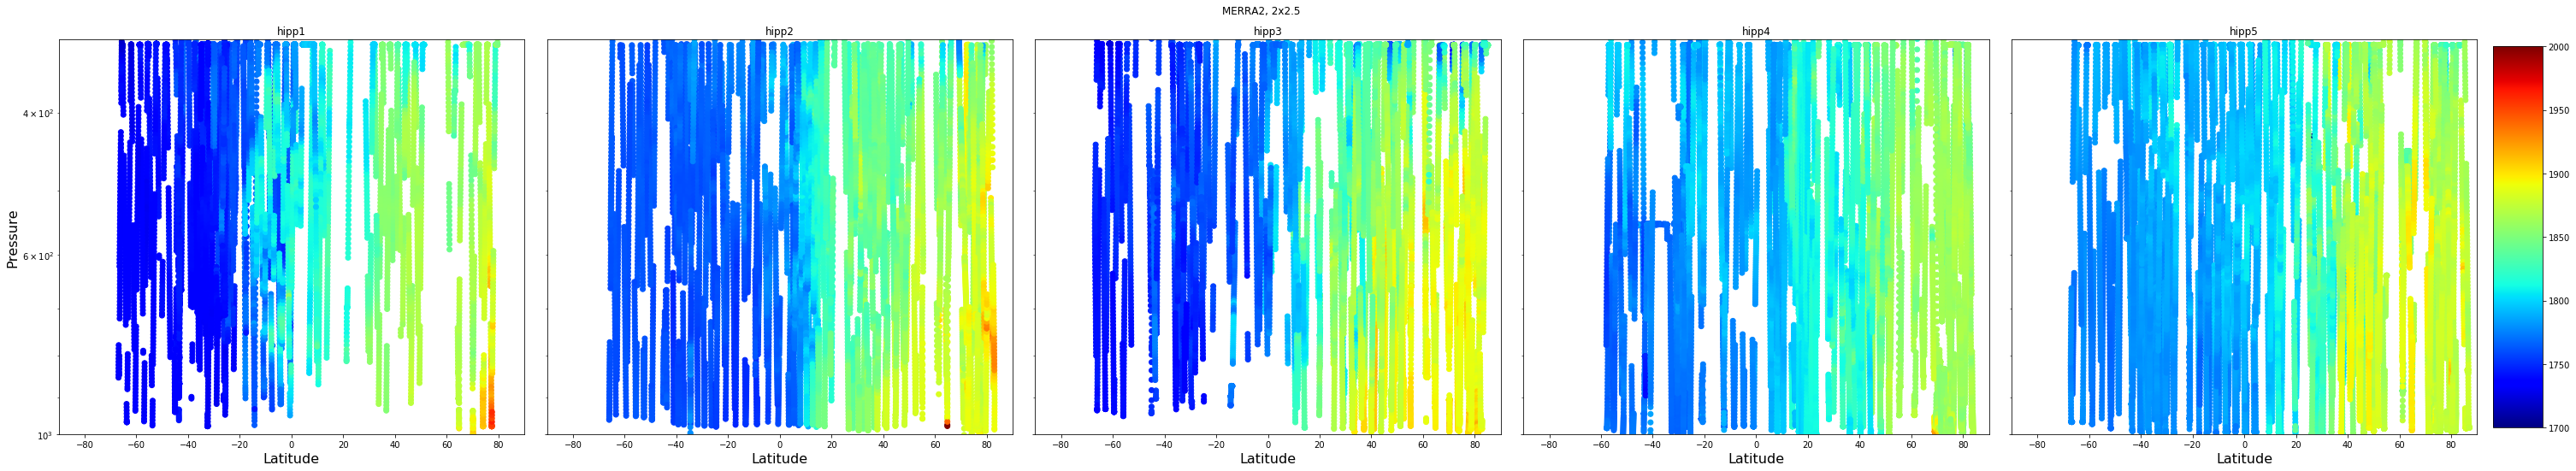

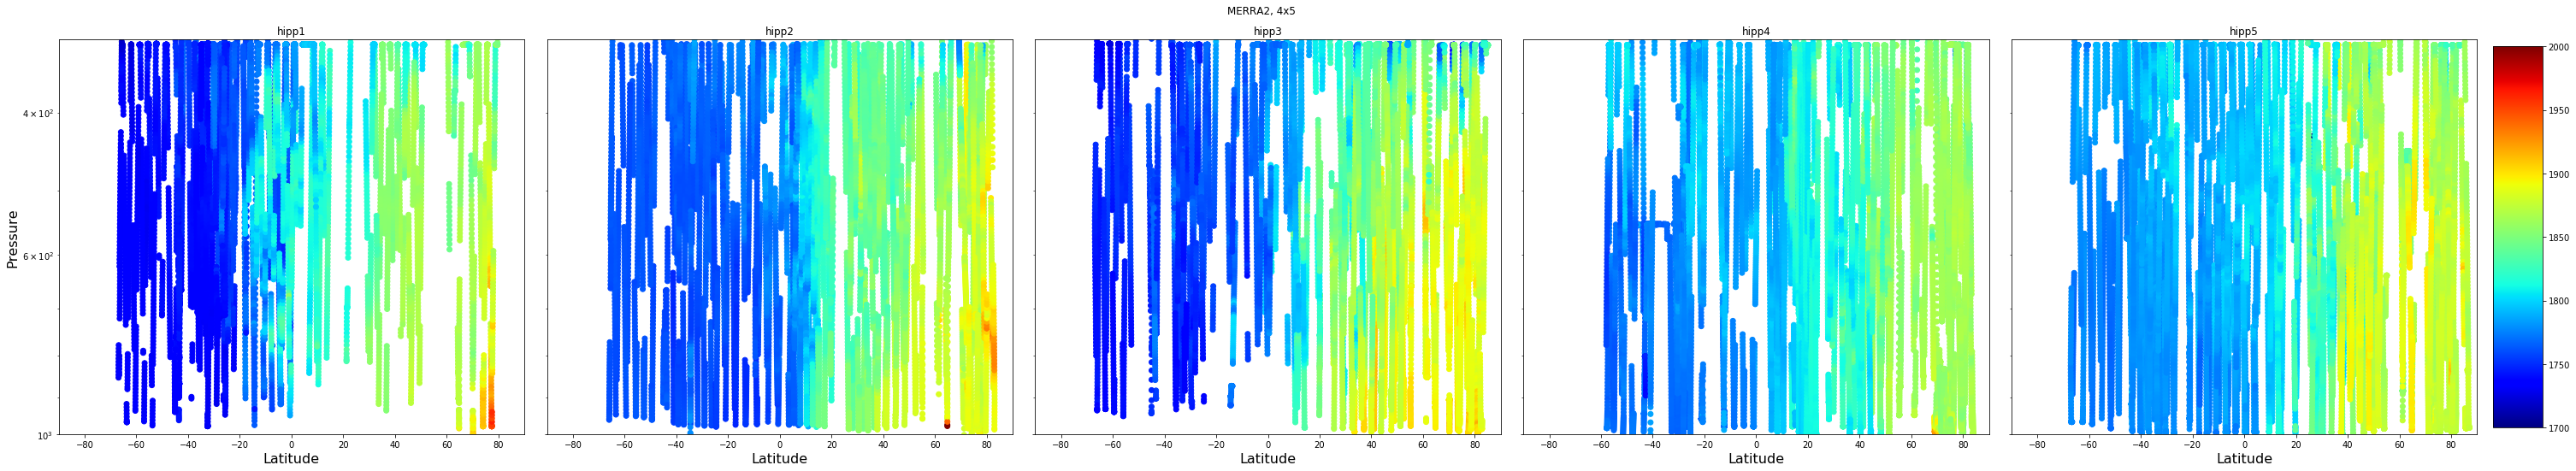

In [10]:
for mr, mr_data in pf_tot.items():
    fig, ax = curtains.curtain(mr_data, 'OBS', absolute=True)
    fig.suptitle(MODEL_RUN_NAMES[mr], y=1.05)
    for i in range(len(ax)):
        ax[i].set_ylim(1000, 325)

### Label Vertical Profiles

In [11]:
hippo_tot = pf_tot.copy()

/Users/hannahnesser/Documents/Harvard/Research/Python/vert_profs.py:35: RuntimeWarning: invalid value encountered in greater
  if (np.all(diff_mov_avg[j:j+threshold] > 0) | np.all(diff_mov_avg[j:j+threshold] < 0)):
/Users/hannahnesser/Documents/Harvard/Research/Python/vert_profs.py:35: RuntimeWarning: invalid value encountered in less
  if (np.all(diff_mov_avg[j:j+threshold] > 0) | np.all(diff_mov_avg[j:j+threshold] < 0)):


-------------------------------
Model Run =  M225
Number of Profiles:   435
-------------------------------
Model Run =  M45
Number of Profiles:   435


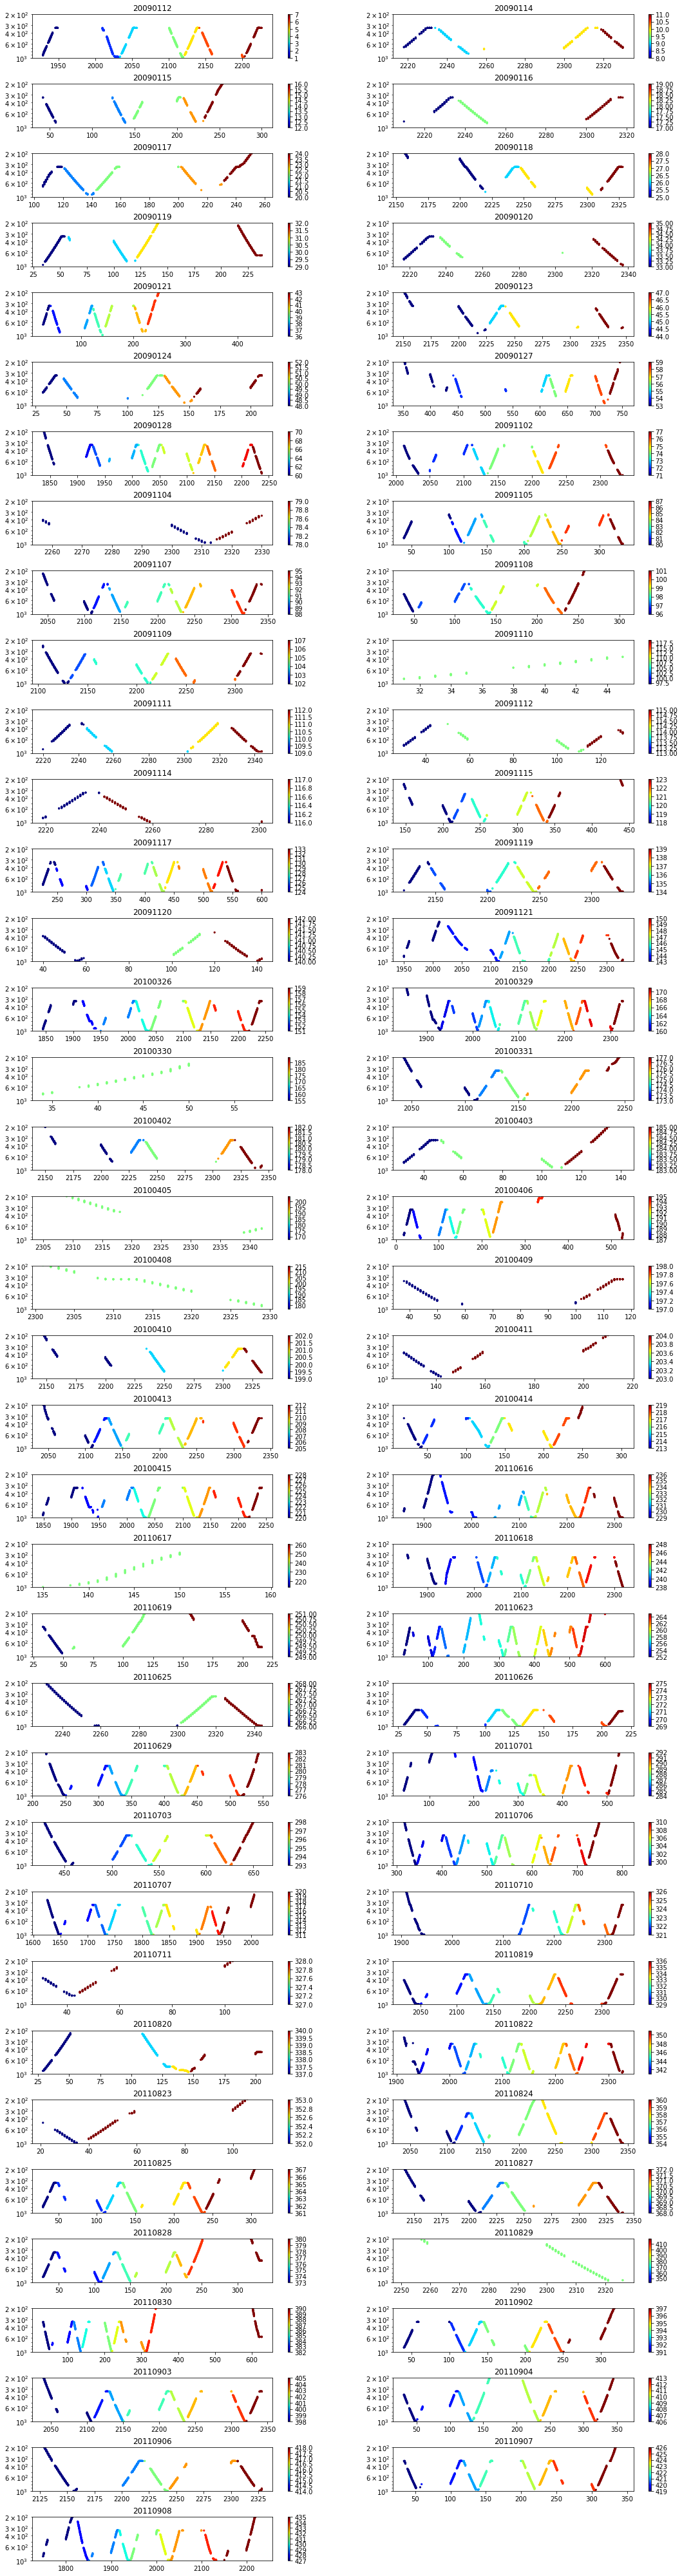

In [12]:
for mr, mr_data in hippo_tot.items():
    # Label vertical profiles in the ATom data
    hippo_tot[mr] = vp.label_vprofs(hippo_tot[mr], rolling_avg_window=30, threshold=12)
    
    # Remove segmented profiles (ie incorrectly identified profiles)
    hippo_tot[mr] = vp.remove_segmented_profs(hippo_tot[mr], label_column='LAB', threshold=50)
    
    # Remove profiles from take-off and landing
    hippo_tot[mr] = vp.remove_takeoff_landing(hippo_tot[mr], label_column='LAB', time_threshold_hr=3)
    
    # Reset indices
    hippo_tot[mr] = vp.reset_vprof_count(hippo_tot[mr], label_column='LAB')
        
    # Print out number of profiles
    print('-------------------------------')
    print('Model Run = ', mr)
    print('Number of Profiles:  ', hippo_tot[mr]['LAB'].max())
    
vp.plot_profiles(hippo_tot['M225'][hippo_tot['M225']['LAB'] > 0], label_column='LAB');

### Total Column Calculations
Calculate the total column concentrations for each vertical profile.

In [13]:
# create pressure bands:
pressure_bands = np.linspace(325, hippo_tot['M225']['PRESS'].max(), 6)

hippo_cols = {}
for mr, mr_data in hippo_tot.items():
    hippo_cols[mr] = tc.calc_tot_cols(hippo_tot[mr], pressure_bands=pressure_bands)

In [14]:
hippo_cols['M45'].head()

,LAB,TYPE,YYYYMMDD,HHMM,LAT,LON,OBS,OBS_AVG,MOD,DIFF
0,2,hipp1,20090112,2010,69.782596,-148.715865,1864.466493,1865.850849,1861.890146,-2.576347
1,4,hipp1,20090112,2101,73.299059,-151.088588,1882.803770,1882.915582,1862.846323,-19.957447
2,6,hipp1,20090112,2142,76.848556,-155.505778,1900.815144,1898.701240,1876.944071,-23.871073
3,21,hipp1,20090117,121,-3.325208,-166.541979,1763.906703,1769.232589,1768.575055,4.668352
4,27,hipp1,20090118,2248,-25.040899,-175.056742,1752.916670,1753.554790,1750.512671,-2.403999


### Final Array Creation

In [15]:
# # We wish to create summary arrays that summarize the difference between observations
# # and different model runs.
hippo_cols_summ = bias.build_summary_df_hippo(hippo_cols)
hippo_cols_summ = hippo_cols_summ.dropna(axis='index')

In [16]:
hippo_cols_summ.head()

,TYPE,LAB,YYYYMMDD,HHMM,LAT,LON,OBS,OBS_AVG,M225,M45,M225_OBS,M45_OBS,M225_M45
0,hipp1,2,20090112,2010,69.782596,-148.715865,1864.466493,1864.993940,1858.308517,1861.890146,-6.157977,-2.576347,-3.581629
1,hipp1,4,20090112,2101,73.299059,-151.088588,1882.803770,1882.915582,1867.839816,1862.846323,-14.963954,-19.957447,4.993492
2,hipp1,6,20090112,2142,76.848556,-155.505778,1900.815144,1898.691330,1872.730439,1876.944071,-28.084705,-23.871073,-4.213632
3,hipp1,21,20090117,121,-3.325208,-166.541979,1763.906703,1769.232589,1765.794913,1768.575055,1.888210,4.668352,-2.780141
4,hipp1,27,20090118,2248,-25.040899,-175.056742,1752.916670,1753.583372,1754.189580,1750.512671,1.272910,-2.403999,3.676909


## Bias Analysis

### Latitudinal Bands

In [17]:
np.any(np.isin(hippo_cols_summ['TYPE'].str[:4], 'hipp'))

True

In [18]:
lat_bands = np.arange(-90, 91, 30)
hippo_cols_lat_band_stats = bias.calc_band_stat(hippo_cols_summ, 'mean', 'LAT', lat_bands)
hippo_cols_lat_band_stds = bias.calc_band_stat(hippo_cols_summ, 'std', 'LAT', lat_bands) 

In [19]:
hippo_cols_lat_band_stats.head()

,TYPE,BAND,OBS,OBS_AVG,M45,M225,M45_OBS,M225_OBS,M225_M45,COUNT
0,hipp1,"(-90, -60]",1733.345643,1733.329465,1742.506410,1741.704345,9.160767,8.358702,-0.802066,1.0
1,hipp1,"(-60, -30]",1735.710177,1735.663987,1742.377633,1741.660438,6.667456,5.950260,-0.717196,1.0
2,hipp1,"(-30, 0]",1767.755737,1769.027317,1768.972966,1767.946339,1.217230,0.190603,-1.026627,4.0
3,hipp1,"(0, 30]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hipp1,"(30, 60]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


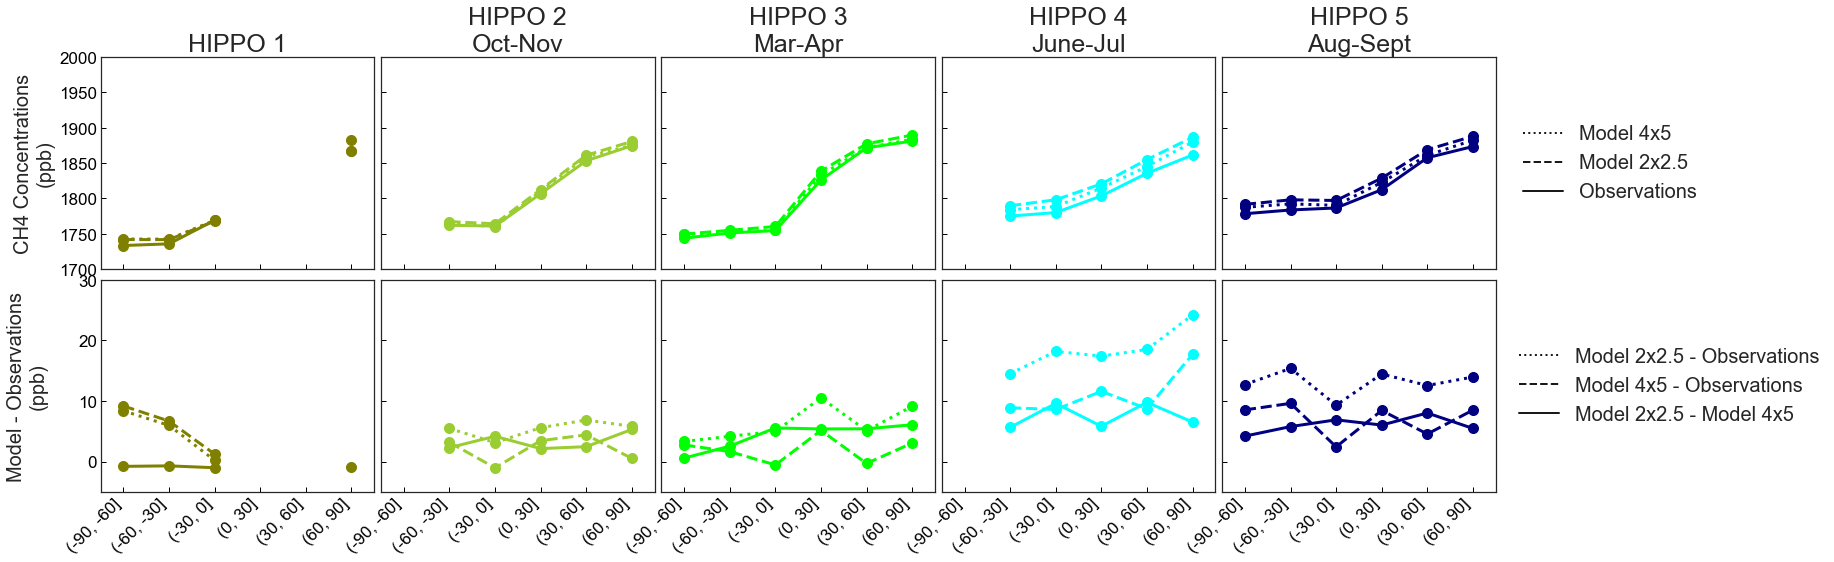

In [20]:
hippo_types = np.unique(hippo_cols_lat_band_stats['TYPE'])
lat_bands = hippo_cols_lat_band_stats['BAND'].unique()
colors = ['Olive', 'YellowGreen', 'Lime', 'Aqua', 'Navy'] # 'DarkOliveGreen', 
linestyles = [':', '--', '-']
labels = ['2x2.5 Model', '4x5 Model', 'Observations']
titles = ['HIPPO 1', 'HIPPO 2\nOct-Nov', 'HIPPO 3\nMar-Apr', 'HIPPO 4\nJune-Jul', 'HIPPO 5\nAug-Sept']

sns.set_style('white')
fig, ax = plt.subplots(2,5,figsize=(25,8), sharex=True)
fig.subplots_adjust(wspace=0.025, hspace=0.05)
for i, hippo in enumerate(hippo_types[:]):
    data = hippo_cols_lat_band_stats[hippo_cols_lat_band_stats['TYPE'] == hippo]
    ax[0,i].set_title(titles[i], fontsize=25)
    for j, quantity in enumerate(['M45', 'M225', 'OBS_AVG']):
        ax[0,i].plot(np.arange(len(lat_bands)), data[quantity], 
                   c=colors[i], marker='.', markersize=20, linestyle=linestyles[j], lw=3,
                   label=labels[j])

    for k, quantity in enumerate(['M225_OBS', 'M45_OBS', 'M225_M45']):
        ax[1,i].plot(np.arange(len(lat_bands)), data[quantity],
               c=colors[i], marker='.', markersize=20, linestyle=linestyles[k], lw=3,
               label='Difference')

    for l in range(2):
        ax[l,i].tick_params(direction='in', length=5, width=1, 
                          which='major', colors='black', top=False,
                          labelsize=17)
        ax[l,i].set_xlim(-0.5,len(lat_bands)-0.5)
        ax[l,i].set_xticks(np.arange(len(lat_bands)))
        if i > 0:
            ax[l,i].set_yticklabels('')
    ax[1,i].set_xticklabels(lat_bands, rotation=45, ha='right')
    ax[1,i].set_ylim(-5,30)
    ax[0,i].set_ylim(1700, 2000)

ax[0,0].set_ylabel('CH4 Concentrations\n(ppb)', fontsize=20)
ax[1,0].set_ylabel('Model - Observations\n(ppb)', fontsize=20, labelpad=30)
# ax[1,2].text(-1.2, -4, 'Band', fontsize=20)

# model_obs_lines = [Line2D([], [], color='0.1', lw=2, ls='-'),
#                    Line2D([], [], color='0.1', lw=2, ls='--')]
# hippo_lines = [Line2D([], [], color=col, lw=2, ls='-') for col in colors]
lines = [Line2D([], [], color='0.1', lw=2, ls=linestyle) for linestyle in linestyles]
labels_0 = ['Model 4x5', 'Model 2x2.5', 'Observations']
labels_1 = ['Model 2x2.5 - Observations', 'Model 4x5 - Observations', 'Model 2x2.5 - Model 4x5']
ax[0,4].legend(lines, labels_0, loc='center right', 
               bbox_to_anchor=(1.8,0.5), fontsize=20)
ax[1,4].legend(lines, labels_1, loc='center right', 
               bbox_to_anchor=(2.25,0.5), fontsize=20)
sns.set_style('dark')